This notebook will take in a list of questions and calculate sentence similarity scores between each of them using the BERT model. We will begin by importing the dataset itself below. Credit for the "how-to" and code below goes to this [fantastic article](https://towardsdatascience.com/bert-for-measuring-text-similarity-eec91c6bf9e1).

In [54]:
import pandas as pd
dataset = 'curated_philosophical_questions'
dat = pd.read_csv('../data/processed/' + dataset + '.csv')
dat

,Person,Source,Link,Question
0,C.B. Daniels,Conversation Starters World,https://conversationstartersworld.com/philosophical-questions/,What harsh truths do you prefer to ignore?
1,C.B. Daniels,Conversation Starters World,https://conversationstartersworld.com/philosophical-questions/,Is free will real or just an illusion?
2,C.B. Daniels,Conversation Starters World,https://conversationstartersworld.com/philosophical-questions/,"Is there a meaning to life? If so, what is it?"
3,C.B. Daniels,Conversation Starters World,https://conversationstartersworld.com/philosophical-questions/,Where is the line between art and not art?
4,C.B. Daniels,Conversation Starters World,https://conversationstartersworld.com/philosophical-questions/,What should be the goal of humanity?
...,...,...,...,...
197,C.B. Daniels,Conversation Starters World,https://conversationstartersworld.com/philosophical-questions/,Should full access to the internet be a fundamental human right?
198,C.B. Daniels,Conversation Starters World,https://conversationstartersworld.com/philosophical-questions/,Has the invention of the atomic bomb made the world a more peaceful place?
199,C.B. Daniels,Conversation Starters World,https://conversationstartersworld.com/philosophical-questions/,"Do you think the singularity will occur? If so, what time frame do you think it will happen in?"
200,C.B. Daniels,Conversation Starters World,https://conversationstartersworld.com/philosophical-questions/,"If we could control emotions through technology, should we?"


Now we will isolate the questions as an array of sentences, which will be fed into a pre-trained "bert-base-nli-mean-tokens" model. We note that there was a "module not found" error in the code below. The maintainer of the sentence-transformers package fixed it and requires the user to install via "pip install -U sentence-transformers." The code below takes a while to run, as the pre-trained model is quite large. 

In [55]:
from sentence_transformers import SentenceTransformer

sentences = dat["Question"].tolist()
sentences[1:5]

model = SentenceTransformer('bert-base-nli-mean-tokens')
sentence_embeddings = model.encode(sentences)
sentence_embeddings.shape

Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction


(202, 768)

From here, we're going to use cosine similarity to determine which questions are most similar to each other. One example of this is below. We compare the initial question to the first five questions after the initial question. We will display the questions and the similarity scores and see if it makes sense. 

In [56]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

cos_sim = cosine_similarity(
    [sentence_embeddings[20]],
    sentence_embeddings
).tolist()

df = pd.DataFrame({'questions': sentences,
            'similarity': cos_sim[0]})

# Arrange by similarity
pd.set_option('display.max_colwidth', None)
display(df.sort_values(by = 'similarity', ascending = False))

,questions,similarity
20,What do you think would be humanity’s reaction to the discovery of extraterrestrial life?,1.000000
133,Should we terraform planets if it means that we may be destroying undiscovered microscopic alien life?,0.794426
108,"If humanity was put on trial by an advanced race of aliens, how would you defend humanity and argue for its continued existence?",0.789634
195,"Given a scale from completely human to completely machine, how far would you choose to augment yourself with robotics? What parts would you augment and why?",0.702363
81,"Assuming evolution is correct, do you think that if humans went extinct another species as intelligent as humans would evolve? If life exists long enough on a planet, is intelligence and consciousness inevitable?",0.689059
...,...,...
54,What activities cause you to feel like you are living life to the fullest?,0.246763
57,How important is play in living a healthy and fulfilling life?,0.236768
43,What is the most important goal every person should have?,0.232671
162,"What would happen to a society in which no one had to work, and everyone was provided enough food/water/shelter/healthcare for free?",0.209976


We were going to run a UMAP on the vector space to get some intuition around what it looks like, but because UMAP has issues with python 3.9 at the moment, we're going to jump right to making a cosine similarity matrix that we will then turn into a graph. 

In [57]:
import sklearn

dist = sklearn.metrics.pairwise.cosine_distances(sentence_embeddings)
dist

# nn = sklearn.neighbors.kneighbors_graph(sentence_embeddings, n_neighbors = 1)
# nn

array([[0.        , 0.46672308, 0.57111883, ..., 0.63191533, 0.55107534,
        0.5685402 ],
       [0.46672308, 0.        , 0.41099066, ..., 0.45024353, 0.4049548 ,
        0.42096013],
       [0.57111883, 0.41099066, 0.        , ..., 0.35539937, 0.483361  ,
        0.4748903 ],
       ...,
       [0.63191533, 0.45024353, 0.35539937, ..., 0.        , 0.46795118,
        0.46762502],
       [0.55107534, 0.4049548 , 0.483361  , ..., 0.46795118, 0.        ,
        0.24336469],
       [0.5685402 , 0.42096013, 0.4748903 , ..., 0.46762502, 0.24336469,
        0.        ]], dtype=float32)

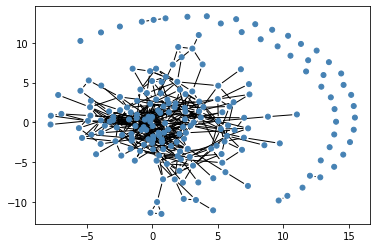

In [58]:
import igraph as ig
import matplotlib.pyplot as plt

dist = np.where(dist == 0, 1, dist) # For the boolean below. Can't figure out compound boolean.
g = ig.Graph.Adjacency(dist < 0.3) # Need to convert to boolean
g = g.as_undirected()
fig, ax = plt.subplots()
ig.plot(g, target=ax)

Now we will do a quick measure of betweenness and eigenvector centrality to get a feel for what questions are the most central. We'll print the top 10 of each.

In [59]:
deg = g.degree()
btw = g.betweenness()
df = pd.DataFrame({'name': dat['Question'], 'degree': deg, 'betweenness': btw})
display(df.sort_values(by='degree', ascending=False))
display(df.sort_values(by='betweenness', ascending=False))

,name,degree,betweenness
118,Are people ethically obligated to improve themselves?,29,777.688921
178,How would the world change if there was an accurate measure of aptitude?,29,1655.064433
31,Is humanity headed in the right or wrong direction?,28,818.181480
136,"If doing something good for others makes us feel good, can there ever be such a thing as pure altruism?",28,837.169388
25,Would things get better or worse if humans focused on what was going well rather than what’s going wrong?,27,1346.615829
...,...,...,...
141,"If I steal a loaf of bread from you and eat it, when does the bread itself cease to be yours and becomes mine?",0,0.000000
28,What do you attribute the biggest successes in your life to? How about your largest failures?,0,0.000000
48,How replaceable are you?,0,0.000000
29,"If freedom is simply being able to do what you want, are animals freer than humans?",0,0.000000


,name,degree,betweenness
178,How would the world change if there was an accurate measure of aptitude?,29,1655.064433
25,Would things get better or worse if humans focused on what was going well rather than what’s going wrong?,27,1346.615829
84,"So, which of your beliefs are most likely to be wrong and which are most liable to be true?",15,1215.024028
189,Is technological progress inevitable as long as humans exist or can it be stopped?,14,1170.988455
95,Why do we resist doing things that we know are good for our well-being while craving things that are detrimental to our well-being?,18,899.112597
...,...,...,...
150,Is poverty in society inevitable?,2,0.000000
149,"What should the role of a government be, what boundaries and limitations should it have?",3,0.000000
96,Is it be possible for humans to create something completely novel and new that is based on nothing that previously existed? Or is human creativity just rearranging and building on previous ideas?,0,0.000000
36,"What is the best way to train people to see the gradients in the world around them instead of just a simplistic “this is good, that is wrong” view of the world?",0,0.000000


From here, we run clustering to see if the the quesitons group into particular themes. We will use Louvain clustering, as it is often used in graph-based analysis.

In [60]:
clust = ig.Graph.community_multilevel(g)
#df = pd.DataFrame({'name': dat['Question'], 'cluster': clust.membership})
df['cluster'] = clust.membership

for i in pd.unique(df['cluster']):
    curr = df[df['cluster'] == i]
    if curr.shape[0] > 5:
        display(curr)


,name,degree,betweenness,cluster
0,What harsh truths do you prefer to ignore?,7,55.381608,0
9,How will humans as a species go extinct?,4,160.202778,0
21,Will religion ever become obsolete?,1,0.000000,0
30,Would you want to know you are going to die before hand or die suddenly without warning?,3,6.900000,0
34,"If you had to guess, what do you think would be the most likely way you’ll die?",3,363.001690,0
52,Does absolute power corrupt absolutely?,4,18.499768,0
53,Why do we judge ourselves by our intentions but judge others by their actions?,13,398.031657,0
59,What is the biggest waste of human potential?,5,24.597792,0
71,Is there inherent order in nature or is it all chaos and chance?,5,100.810489,0
84,"So, which of your beliefs are most likely to be wrong and which are most liable to be true?",15,1215.024028,0


,name,degree,betweenness,cluster
1,Is free will real or just an illusion?,12,241.187520,1
68,"If the universe is finite, what would beyond the edge of the universe be like?",1,0.000000,1
92,Can rational thought exist without language?,6,139.417129,1
94,Are there limits to human creativity?,14,490.986730,1
101,Is a sense of humor a byproduct of consciousness or something else entirely?,8,94.239727,1
113,"With no laws or rules to influence your behavior, how do you think you would behave?",4,59.235486,1
119,Is privacy a right?,9,96.668748,1
123,Should there be limitations on the right to free speech?,7,149.937334,1
156,without money or a barter system)?,2,0.000000,1
175,Can a society exist without laws?,6,288.279615,1


,name,degree,betweenness,cluster
2,"Is there a meaning to life? If so, what is it?",12,134.355344,2
4,What should be the goal of humanity?,8,147.448542,2
5,"Does fate exist? If so, do we have free will?",11,124.672021,2
7,Why do we dream?,1,0.000000,2
8,Where does your self-worth come from?,12,114.828255,2
...,...,...,...,...
152,"What would a utopia be like, how would it function and continue to exist?",9,217.399131,2
165,"If everyone said what they were actually thinking, what would happen to society?",3,95.004363,2
178,How would the world change if there was an accurate measure of aptitude?,29,1655.064433,2
184,Does marriage as an institution need to be updated or is it fine how it is?,2,7.748881,2


,name,degree,betweenness,cluster
6,What does it mean to live a good life?,15,208.456802,4
22,"If you could teach everyone in the world one concept, what concept would have the biggest positive impact on humanity?",10,165.583595,4
24,"Does hardship make a person stronger? If so, under what conditions and at what point is it too much hardship? If not, what makes a person stronger?",3,3.238013,4
33,What is the best way for a person to attain happiness?,11,31.746459,4
41,"Is it more important to help yourself, help your family, help your society, or help the world?",12,159.137633,4
...,...,...,...,...
138,Do all people have equal value regardless of their actions or is a person’s value based on their actions?,8,25.575747,4
161,Is the human tendency to create groups an overall positive or a negative trait in terms of general human flourishing?,11,281.295975,4
168,What is the most important right our government allows for?,5,126.170208,4
173,"In an ideal government, what should a good citizen provide to their government and what should that government provide that good citizen?",5,82.186264,4


,name,degree,betweenness,cluster
10,Is it possible to live a normal life and not ever tell a lie?,1,0.000000,5
12,Is the meaning of life the same for animals and humans?,1,0.000000,5
25,Would things get better or worse if humans focused on what was going well rather than what’s going wrong?,27,1346.615829,5
35,Is it better for a person to have a broad knowledge base or a deep knowledge base?,6,10.582227,5
37,Is intelligence or wisdom more useful?,21,211.171020,5
38,Which of your beliefs are justified and which ones aren’t?,21,439.560895,5
51,Which is a more valid point of view or are they both equally valid?,15,48.942876,5
55,Does knowledge have intrinsic value or does it need to have a practical use to have value?,27,806.193593,5
72,What in life is truly objective and not subjective?,8,163.341789,5
77,Is it possible that some animals are self-aware and think about their ability to think?,3,14.044086,5


,name,degree,betweenness,cluster
20,What do you think would be humanity’s reaction to the discovery of extraterrestrial life?,3,310.000000,13
56,What would you genetically change about humans to make them a better species?,8,363.239846,13
66,Is math something that humans created or something we discovered? Is looking at reality mathematically an accurate representation of how things work?,3,156.000000,13
69,"What is the best path to find truth; science, math, art, philosophy, or something else?",1,0.000000,13
76,"If every neuron in a human was accurately simulated in a computer, would it result in human consciousness?",2,0.000000,13
...,...,...,...,...
193,"Will we keep leaping to even greater technological and scientific breakthroughs that radically change society, or will the rate of progress slow and humanity’s progress be limited to incremental improvements?",5,10.508201,13
194,"If a robust and cheap genetic engineering industry existed, would you have your genes edited? If so, what genetic changes would you choose to make? If not, why not?",3,30.548688,13
195,"Given a scale from completely human to completely machine, how far would you choose to augment yourself with robotics? What parts would you augment and why?",4,463.886036,13
200,"If we could control emotions through technology, should we?",5,230.931859,13


,name,degree,betweenness,cluster
23,Is suffering a necessary part of the human condition? What would people who never suffered be like?,5,239.825854,14
91,"Is it possible that someone’s genes might affect their political leanings? If no, why not? If so, what would be the ramifications?",7,211.139200,14
95,Why do we resist doing things that we know are good for our well-being while craving things that are detrimental to our well-being?,18,899.112597,14
105,"When, if ever, is taking a human life justified?",1,0.000000,14
107,"Without religion would people become more, less, or be equally morally corrupt?",9,161.041084,14
125,Should euthanasia be legal? Why or why not?,3,161.255132,14
126,"If scientists could accurately predict who was more likely to commit crimes, what should society do with that information?",3,12.657086,14
127,Do business owners have the right to refuse service to customers?,1,0.000000,14
130,"If you can save another’s life and don’t because doing so would break the law, are you ethically justified in your decision?",12,483.672564,14
134,Does anonymity encourage people to misbehave or does it reveal how people would choose to act all the time if they could?,7,95.733422,14


,name,degree,betweenness,cluster
26,What benefits does art provide society? Does art hurt society in any way?,2,8.128854,15
61,Does jealously have value in driving humans to improve themselves or is it a purely negative emotion?,11,497.032394,15
115,"If it was discovered that personality traits were partly genetic and could be removed with gene therapy, would it be ethical to edit out negative character traits that harm others like extreme aggression, compulsive lying, or cruelty?",5,126.270585,15
120,"At what point is overthrowing a government ethical, considering all the violence a revolution usually entails?",1,0.000000,15
135,"What is the most fertile soil for hatred? Fear, ignorance, jealousy, or something else entirely? Is it possible that some people are genetically predisposed to hatred?",3,8.648092,15
139,Why are humans so fascinated by mass murderers if their actions are universally considered evil and vile?,4,173.054847,15
140,How does this human trait of morality dependent on distance shape our world?,10,187.946284,15
148,Do people in wealthier countries have a moral obligation to help those in poorer countries?,8,173.219285,15
150,Is poverty in society inevitable?,2,0.000000,15
163,Is the cultural trend of individualism and the rejection of collectivism a beneficial or detrimental trend?,12,495.941042,15


Now, we're going to pull the graph out as an edgelist and get a feel for who is connected to who. We will then export the edgelist for import into Neo4J. 

TODO 1) make this a searchable umap. 2) place this into neo4j 3) set up the virtual environemnt and stop installing anything to the regular environemnt

In [61]:
el = g.get_edge_dataframe()
el

,source,target
edge ID,,
0,2,4
1,1,5
2,2,5
3,2,8
4,5,8
...,...,...
570,189,201
571,190,201
572,191,201


Now we have to convert the edges from their edge IDs to the questions that are in the order of the IDs. The reason we're seeing numbers right now is that the original adjacency matrix was made with the IDs and not the questions themselves. We're going to do that using a simple conversion function. We're going to do this by creating a dictionary. 

In [62]:
q_dict = {}

for i in range(0, len(sentences)):
    q_dict[i] = sentences[i]

q_dict

{0: 'What harsh truths do you prefer to ignore?',
 1: 'Is free will real or just an illusion?',
 2: 'Is there a meaning to life? If so, what is it?',
 3: 'Where is the line between art and not art?',
 4: 'What should be the goal of humanity?',
 5: 'Does fate exist? If so, do we have free will?',
 6: 'What does it mean to live a good life?',
 7: 'Why do we dream?',
 8: 'Where does your self-worth come from?',
 9: 'How will humans as a species go extinct?',
 10: 'Is it possible to live a normal life and not ever tell a lie?',
 11: 'Does a person’s name influence the person they become?',
 12: 'Is the meaning of life the same for animals and humans?',
 13: 'If someone you loved was killed in front of you, but someone created a copy of them that was perfect right down to the atomic level, would they be the same person and would you love them just as much?',
 14: 'If you could become immortal on the condition you would NEVER be able to die or kill yourself, would you choose immortality?',
 

In [63]:
e1 = [q_dict[i] for i in el['source']]
e2 = [q_dict[i] for i in el['target']]

el_df = pd.DataFrame({'edge1': e1, 'edge2': e2})
el_df 



,edge1,edge2
0,"Is there a meaning to life? If so, what is it?",What should be the goal of humanity?
1,Is free will real or just an illusion?,"Does fate exist? If so, do we have free will?"
2,"Is there a meaning to life? If so, what is it?","Does fate exist? If so, do we have free will?"
3,"Is there a meaning to life? If so, what is it?",Where does your self-worth come from?
4,"Does fate exist? If so, do we have free will?",Where does your self-worth come from?
...,...,...
570,Is technological progress inevitable as long as humans exist or can it be stopped?,Is there a limit to what humans can create through technology and science?
571,Is true artificial intelligence possible with our current technology and methods of programming?,Is there a limit to what humans can create through technology and science?
572,What scientific breakthrough would have the biggest effect on humanity?,Is there a limit to what humans can create through technology and science?
573,"Given a scale from completely human to completely machine, how far would you choose to augment yourself with robotics? What parts would you augment and why?",Is there a limit to what humans can create through technology and science?


In [65]:
el_df.to_csv(dataset + '_edgelist_dist_0.3.csv', encoding='utf-8-sig')
df.to_csv(dataset + '_analyzed.csv', encoding='utf-8-sig')